#Introduction
La Compression JPEG (Joint Photographic Experts Group) est une technique couramment utilisée pour réduire la taille des fichiers d'images sans compromettre de manière significative leur qualité visuelle. Ce premier Notebook sert d'illustration à notre compréhension de la Transformée en Cosinus Discrète (DCT), une technique fondamentale utilisée dans la compression JPEG. Nous explorerons les raisons pour lesquelles la DCT revêt un intérêt particulier et comment ses coefficients peuvent exercer une influence sur le rendu final de l'image. Ce jupyter étant interractif, il est fortement encourager de faire varier les curseurs pour mieux comprendre les concepts abordés.

In [ ]:
#Importations des bibliothèques nécessaires
from PIL import Image
import numpy as np
from PIL import ImageOps
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from matplotlib.patches import Rectangle
#!pip install matplotlib ipywidgets
#!pip install huffman

# 1. Pré-traitemnet de l'image

Nous allons utiliser une image de 637 pixels de largeur, 861 pixels de hauteur et utilisant les 3 canaux de couleur (R,G,B). Nous retrouvons ces informations ci-dessous. Nous réprésentons l'image comme une matrice de pixels.

In [ ]:
# Charger l'image RGB
image_path = './Image1.png'
try:
    image = Image.open(image_path)
except FileNotFoundError:
    print(f"Erreur : Fichier '{image_path}' introuvable.")

# Convertir l'image en une matrice NumPy de pixels
matrice_pixel = np.array(image)
print("Dimensions de la matrice des pixels:" , matrice_pixel.shape)


Dimensions de la matrice des pixels: (637, 861, 3)


Nous commençons par convertir notre image RGB dans l'espace YCbCr et appliquons un échantillonnage de chrominance.

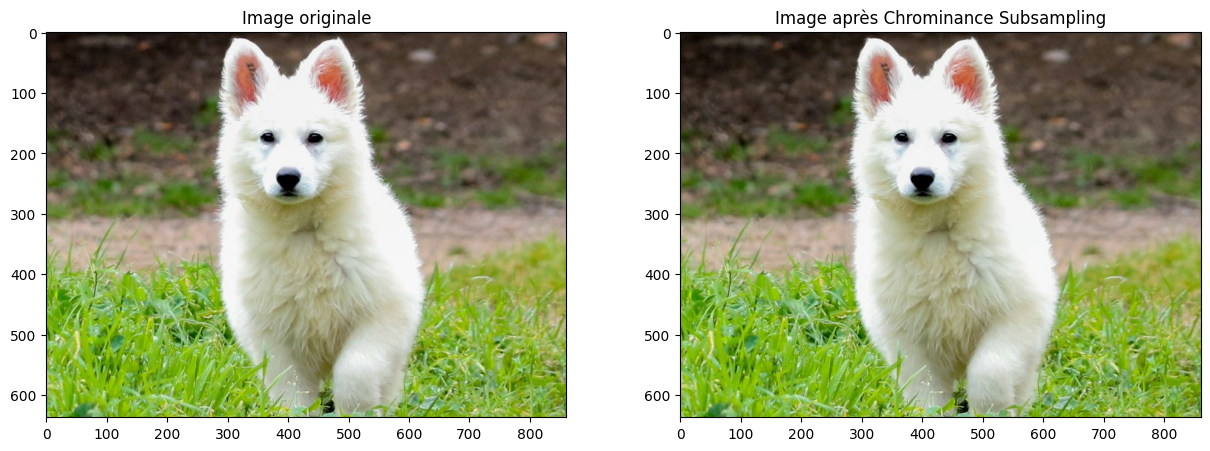

In [ ]:
def rgb_to_ycbcr(rgb_image):
    # Convertir une image RGB en espace colorimétrique YCbCr
    if rgb_image.mode != 'RGB':
        raise ValueError("L'image doit être en mode RGB.")

    # Extraire les canaux RGB
    r, g, b = rgb_image.split()

    # Convertir en tableaux NumPy
    r_array = np.array(r, dtype=np.float32)
    g_array = np.array(g, dtype=np.float32)
    b_array = np.array(b, dtype=np.float32)

    # Appliquer la conversion YCbCr
    y_array = 0.299 * r_array + 0.587 * g_array + 0.114 * b_array
    cb_array = 128 - 0.1687 * r_array - 0.3313 * g_array + 0.5 * b_array
    cr_array = 128 + 0.5 * r_array - 0.419 * g_array - 0.081 * b_array

    # Limiter les valeurs aux plages valides
    y_array = np.clip(y_array, 0, 255)
    cb_array = np.clip(cb_array, 0, 255)
    cr_array = np.clip(cr_array, 0, 255)

    # Regrouper les canaux Y, Cb, Cr
    ycbcr_array = np.stack((y_array, cb_array, cr_array), axis=-1)

    # Convertir les valeurs en entiers non signés 8 bits
    ycbcr_array = ycbcr_array.astype('uint8')

    # Créer une image YCbCr à partir du tableau NumPy
    ycbcr_image = Image.fromarray(ycbcr_array)

    return ycbcr_image

# Appliquer la conversion et le sous-échantillonnage
ycbcr_image = rgb_to_ycbcr(image)

# Convertir en tableau NumPy
ycbcr_array = np.array(ycbcr_image)

# Définir la taille du bloc
block_size = 2

# Obtenez la hauteur et la largeur de l'image
height, width, _ = ycbcr_array.shape

# Créer une copie de l'image pour stocker le résultat
ycbcr_array_averaged = ycbcr_array.copy()

# Diviser l'image en blocs 2x2 et faire la moyenne des pixels pour chaque bloc
for i in range(0, height, block_size):
    for j in range(0, width, block_size):
        # Extraire un bloc 2x2 de l'image Y
        block = ycbcr_array[i:i+block_size, j:j+block_size, 0]

        # Calculer la moyenne des pixels dans le bloc
        average_value = np.mean(block)

        # Remplacer tous les pixels du bloc par la moyenne calculée
        ycbcr_array_averaged[i:i+block_size, j:j+block_size, 0] = average_value

ycbcr_image_after_subsampling = Image.fromarray(ycbcr_array.astype(np.uint8), 'YCbCr')

# Créer une figure avec 1 ligne et 3 colonnes
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Afficher l'image originale
axes[0].imshow(image)
axes[0].set_title('Image originale')

# Afficher l'image après sous-échantillonnage de chrominance
axes[1].imshow(ycbcr_image_after_subsampling)
axes[1].set_title('Image après Chrominance Subsampling')

plt.show()


Nous allons maintenant soustraire une valeur constante (comme 128) de chaque composante de couleur pour centrer les valeurs autour de zéro.


In [ ]:
def centralisation(ycbcr_array):
    # Créer une matrice de soustraction de 128 avec la même forme que ycbcr_array
    soustraction_128 = np.full_like(ycbcr_array, 128, dtype=int)

    # Soustraire individuellement 128 à chaque valeur
    ycbcr_centralized = ycbcr_array - soustraction_128
    return ycbcr_centralized

# Appeler la fonction avec votre ycbcr_array
ycbcr_array = centralisation(ycbcr_array)

# 2.  Encodeur JPGEG


## 2.1 Représentation de l'image en signal

Dans l'espace colorimétrique YCbCr, la première composante est la composante Y, qui représente la luminance. Nous allons commencer par extraire le canal Y (luminance) de notre image d'origine qui a été convertie en YCbCr et échantillonnée. Les principes que nous aborderons à partir de maintenant s'appliqueront également aux autres composantes Cb et Cr.

Text(0.5, 1.0, 'Image en niveaux de gris (Y channel)')

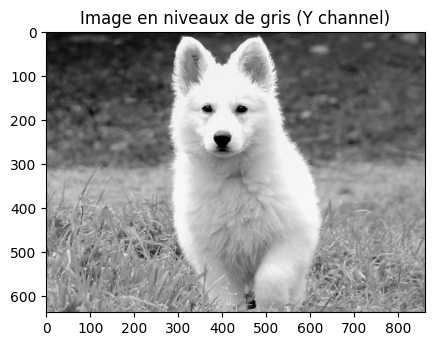

In [ ]:
# Extraire le canal Y (niveau de gris) de l'image YCbCr
y_channel, cb_channel, cr_channel = np.split(ycbcr_array, 3, axis=-1)
# Afficher l'image en niveaux de gris
plt.figure(figsize=(8, 8))
plt.subplot(211)
plt.imshow(y_channel,cmap='gray')
plt.title('Image en niveaux de gris (Y channel)')

Nous allons traiter l'image comme un signal. Si nous découpons une rangée particulière de l'image, nous devrions obtenir une rangée de pixels, chacun de valeur entre 0 et 255. Et comme nous avons centré nos valeurs en soustrayant 128, nous obtenons un signal avec des valeurs entre -128 et 127.
Vous pouvez utiliser le curseur et changer "indexligne" pour voir les signaux générés par chaque ligne correspondant à une portion de l'image.

In [ ]:
# Sélectionner un indice de ligne spécifique pour créer le signal
def update_plot(indexligne):
    # Sélectionner la ligne spécifique pour créer le signal
    signal = y_channel[indexligne, :]

    # Créer une image avec une seule ligne
    image_with_line = np.zeros_like(y_channel)
    image_with_line[indexligne, :] = signal

    # Effacer la figure précédente (pas vraiment nécessaire)
    # plt.clf()

    # Afficher à la fois l'image avec la ligne spécifique et le signal
    plt.figure(figsize=(8, 8))

    # Afficher l'image avec la ligne spécifique
    plt.subplot(211)
    plt.imshow(image_with_line, cmap='gray', aspect='auto')
    plt.title(f'Ligne {indexligne} de l\'image en niveaux de gris (canal Y)')

    # Afficher le signal en bleu un peu plus foncé (par exemple, RGB(0, 0, 128))
    plt.subplot(212)
    plt.plot(signal, color='#000080')  # Utiliser une valeur RGB personnalisée (bleu foncé)
    plt.title(f'Signal de la ligne {indexligne}')

    # Ajuster l'espacement entre les sous-graphiques
    plt.tight_layout()

    # Afficher la figure
    plt.show()

# Créer un widget interactif avec une barre de défilement pour choisir la ligne
interact(update_plot, indexligne=IntSlider(min=0, max=y_channel.shape[0]-1, step=1, value=100))

# Afficher la figure initiale
plt.show()


interactive(children=(IntSlider(value=100, description='indexligne', max=636), Output()), _dom_classes=('widge…

L'image d'origine peut être subdivisée en sous-blocs de 8x8 pixels. Étant donné que chaque bloc peut être traité indépendamment des autres, nous allons nous concentrer sur un seul bloc. Vous pouvez choisir ci-dessous quel bloc de l'image d'origine vous souhaitez utiliser en modifiant les curseurs "ligne" (pour vous déplacer de haut en bas de l'image) et "colonne" (pour vous déplacer de droite à gauche de l'image). Nous allons notamment nous concentrer sur une ligne de ce bloc et représenter les valeurs correspondantes sous la forme d'un signal. Vous pouvez utiliser le curseur "ligne_extraite" pour choisir la ligne du bloc à tracer.

In [ ]:
# Coordonnées de la région 8*8 par défaut
ligne_par_defaut, colonne_par_defaut = 50, 100
ligne_extraite_par_defaut = 0  # Ajout de la valeur par défaut pour ligne_extraite

# Variables pour stocker les blocs choisis
bloc_8x8_choisi = None
bloc_1x8_choisi = None
ligne_extraite = ligne_extraite_par_defaut  # Ajout de la ligne_extraite ici


def mise_a_jour_tracé(ligne, colonne, ligne_extraite=ligne_extraite_par_defaut):  # Utiliser la valeur par défaut
    global bloc_8x8_choisi, bloc_1x8_choisi  # Utiliser le mot-clé 'global' uniquement pour les variables globales

    ligne = int(ligne)  # Convertir la valeur du curseur en entier
    ligne_extraite = int(ligne_extraite)  # Convertir la valeur du curseur en entier
    # Supposons que y_channel soit défini ailleurs dans votre code
    bloc_8x8 = y_channel[ligne:ligne+8, colonne:colonne+8]

    # Extraire la ligne spécifiée par le curseur ligne_extraite du bloc 8x8
    bloc_1x8 = bloc_8x8[ligne_extraite, :]

    # Stocker les blocs dans les variables globales renommées
    bloc_8x8_choisi = bloc_8x8
    bloc_1x8_choisi = bloc_1x8

    # Créer explicitement la figure et les sous-graphiques
    fig, axs = plt.subplots(4, 1, figsize=(10, 10))

    # Afficher l'image en niveaux de gris avec le bloc 8*8 choisi mise en évidence
    axs[0].imshow(y_channel, cmap='gray')
    axs[0].set_title('Image en niveaux de gris (Canal Y) avec le bloc 8x8 choisi mise en évidence')
    rect = Rectangle((colonne, ligne), 8, 8, linewidth=2, edgecolor='red', facecolor='none', label='Bloc 8x8 choisi')
    axs[0].add_patch(rect)

    # Afficher la partie extraite
    axs[1].imshow(bloc_8x8, cmap='gray')
    axs[1].set_title("Bloc de taille (8x8) extrait de l'image sur le canal Y")

    # Ajouter le curseur horizontal pour indiquer quelle partie de bloc_8x8 est extraite
    axs[1].axhline(ligne_extraite, color='green', linestyle='--', linewidth=2, label='Ligne extraite')

    # Afficher la ligne extraite
    axs[2].imshow(bloc_1x8.reshape(1, 8), cmap='gray')  # Reshape pour afficher en tant que ligne
    axs[2].set_title('Ligne extraite du bloc 8x8 choisi du canal Y')

    # Afficher le signal de la ligne extraite
    axs[3].plot(bloc_1x8, marker='o', color='#000080', label='Signal de la ligne extraite')
    axs[3].set_title('Signal de la ligne extraite')

    # Ajouter une légende à la figure à gauche
    legend = fig.legend(loc='center left', bbox_to_anchor=(0.05, 0.5), borderaxespad=0.1)

    plt.subplots_adjust(hspace=0.5)
    plt.show()

# Créer un widget interactif avec des barres de défilement pour choisir les coordonnées de la région
interact(mise_a_jour_tracé,
         ligne=IntSlider(min=0, max=y_channel.shape[0]-8, step=1, value=ligne_par_defaut),
         colonne=IntSlider(min=0, max=y_channel.shape[1]-8, step=1, value=colonne_par_defaut),
         ligne_extraite=IntSlider(min=0, max=7, step=1, value=0))  # Curseur pour choisir la ligne extraite

interactive(children=(IntSlider(value=50, description='ligne', max=629), IntSlider(value=100, description='col…

<function __main__.mise_a_jour_tracé(ligne, colonne, ligne_extraite=0)>

Grâce à ces graphiques, qui représentent l'image sous forme de signal, nous pouvons analyser ses composantes de fréquence. En ajustant les curseurs, nous observons que les fréquences élevées correspondent à des variations rapides entre les pixels, tandis que les fréquences basses sont associées à des changements plus progressifs. Dans l'exemple ci-dessous, pour visualiser le cas des fréquences élevées, nous avons utilisé les valeurs de curseur suivantes : ligne =445 , colonne = 445 et ligne extraite = 6. En revanche, pour examiner le cas des fréquences basses, nous avons utilisé les valeurs de curseur suivantes : ligne = 356 , colonne = 283 et ligne extraite = 7.

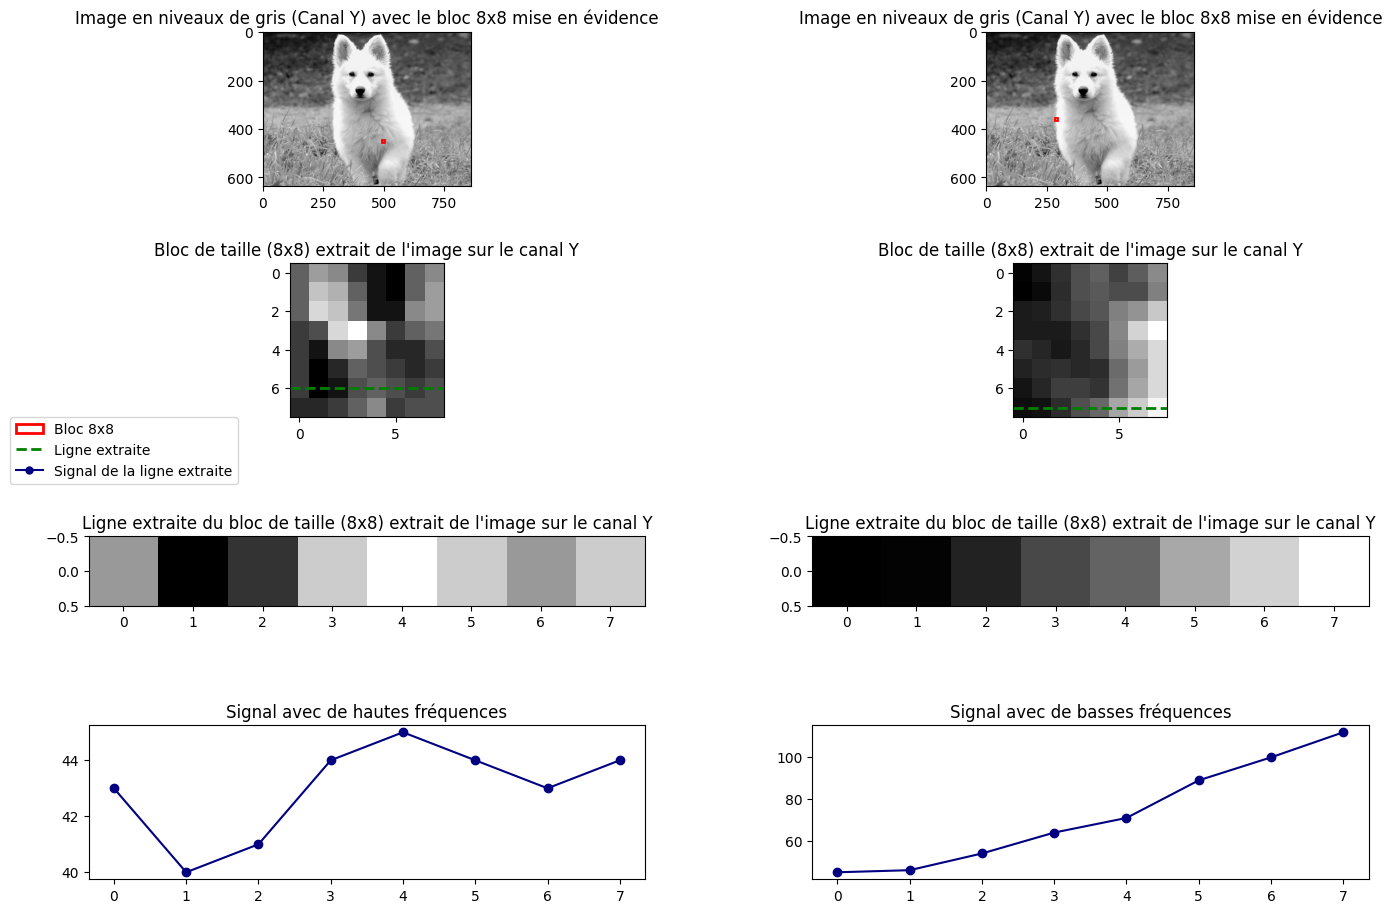

In [ ]:
# Coordonnées de la région 8*8 par défaut
ligne_par_defaut_1, colonne_par_defaut_1 = 445, 491
ligne_par_defaut_2, colonne_par_defaut_2 = 356, 283

# Fonction pour mise à jour du tracé
def mise_a_jour_tracé(axs, ligne, colonne, ligne_extraite, title):
    ligne = int(ligne)
    ligne_extraite = int(ligne_extraite)
    region_8x8 = y_channel[ligne:ligne+8, colonne:colonne+8]
    region_1x8 = region_8x8[ligne_extraite, :]

    rect = Rectangle((colonne, ligne), 8, 8, linewidth=2, edgecolor='red', facecolor='none', label='Bloc 8x8')
    axs[0].add_patch(rect)

    axs[1].axhline(ligne_extraite, color='green', linestyle='--', linewidth=2, label='Ligne extraite')

    axs[3].plot(region_1x8, marker='o', color='#000080', label='Signal de la ligne extraite')

    axs[0].imshow(y_channel, cmap='gray')
    axs[0].set_title('Image en niveaux de gris (Canal Y) avec le bloc 8x8 mise en évidence')

    axs[1].imshow(region_8x8, cmap='gray')
    axs[1].set_title("Bloc de taille (8x8) extrait de l'image sur le canal Y")

    axs[2].imshow(region_1x8.reshape(1, 8), cmap='gray')
    axs[2].set_title("Ligne extraite du bloc de taille (8x8) extrait de l'image sur le canal Y")

    axs[3].set_title('Signal de la ligne extraite')

    # Titre de la figure
    axs[0].annotate(title, xy=(0.5, 1.05), xycoords='axes fraction', ha='center', va='center', fontsize=14)

# Créer explicitement la figure et les sous-graphiques
fig, axs = plt.subplots(4, 2, figsize=(16, 11))

# Mettre à jour le tracé pour la première figure
mise_a_jour_tracé(axs[:, 0], ligne_par_defaut_1, colonne_par_defaut_1, 6, '')
axs[3, 0].set_title('Signal avec de hautes fréquences')  # Ajouter le titre

# Mettre à jour le tracé pour la deuxième figure
mise_a_jour_tracé(axs[:, 1], ligne_par_defaut_2, colonne_par_defaut_2, 7, '')
axs[3, 1].set_title('Signal avec de basses fréquences')  # Ajouter le titre

# Ajuster l'espace entre les sous-graphiques
plt.subplots_adjust(wspace=0.3, hspace=0.5, left=0.1, right=0.9)

# Ajouter la légende à gauche
legend = fig.legend(handles=[Rectangle((0, 0), 1, 1, fc="white", edgecolor='red', linewidth=2),
                            plt.Line2D([0], [0], color='green', linestyle='--', linewidth=2),
                            plt.Line2D([0], [0], marker='o', color='#000080', markersize=5, label='Signal de la ligne extraite')],
                   labels=['Bloc 8x8', 'Ligne extraite', 'Signal de la ligne extraite'],
                   loc='center left', bbox_to_anchor=(0.05, 0.5), borderaxespad=0.1)

# Afficher les deux figures côte à côte
plt.show()

Deux aspects clés des fréquences dans les images sont cruciaux pour la compression JPEG :

1. Les images du monde réel tendent à contenir davantage de composantes de fréquence basses. Autrement dit, si l'on prend une portion aléatoire de l'image, il est probable que les pixels dans cette zone changent de manière relativement lente.

2. Le système visuel humain est généralement moins sensible aux détails de fréquence élevée dans les images.

JPEG exploite ces principes en éliminant de manière stratégique les composantes de fréquence élevée moins significatives et moins fréquentes d'une image, permettant ainsi une compression plus efficace.

Cependant, comment parvient-on à extraire ces composantes de fréquence à partir d'une image ?

## 2.2 Transformée en Cosinus Discrète (DCT)

La réponse à cette question réside dans une opération appelée la transformation en cosinus discrète, ou la DCT. La DCT peut être appliquée à une entrée de n'importe quelle taille, mais pour simplifier, concentrons-nous sur l'entrée de 8 pixels choisie précédemment. Imaginons que ces 8 pixels forment un signal, bien que nous ne puissions jamais être certains de l'aspect exact du signal avec seulement 8 points.

La DCT prend une entrée de points échantillonnés de notre signal d'origine notés `x = (x₀, x₁, ..., xₙ₋₁)` et nous donne une sortie de la même taille `X = (X₀, X₁, ..., Xₙ₋₁)`. L'algorithme DCT fonctionne en transformant le signal d'entrée en une série de coefficients qui représentent les fréquences du signal. Ces coefficients représentent les poids des ondes cosinus de différentes fréquences qui contribuent au signal d'origine. En effet, le signal d'origine peut être décomposé en une somme d'ondes cosinus plus simples avec des poids variés.

Les `Xₖ` s'obtiennent à partir des xn grâce à la formule suivante, obtenue numériquement grâce aux fonctions 'apply_dct' et 'apply_dct_1D' détaillées dans le deuxième notebook Méthodologie.ipynb." :

Soit `x = (x₀, x₁, ..., xₙ₋₁)` un signal d'entrée discret de taille `N`=8 ici, où `xₙ` représente l'échantillon à l'indice `n`, avec `n` un entier naturel compris entre 0 et `N-1`=7. La DCT transforme ce signal en une série de coefficients `X = (X₀, X₁, ..., Xₙ₋₁)`, où chaque `Xₖ` représente le poids de la composante cosinus à la fréquence `k` dans le signal d'origine.

La formule de la DCT pour obtenir `Xₖ` à partir de `x` est définie comme suit:

$$ Xₖ = \sqrt{\frac{2}{N}} \cdot Cₖ \cdot \sum_{n=0}^{N-1} xₙ \cdot \cos\left(\frac{\pi(2n + 1)k}{2N}\right) $$



où :
- `N` est la taille de l'échantillon du signal, un entier.
- `k` est l'index du coefficient DCT, avec `0 ≤ k ≤ N-1`, un entier.
- `xₙ` sont les échantillons du signal d'entrée, avec `0 ≤ n ≤ N-1`, et `n` est un entier naturel.
- `Cₖ` est le facteur de normalisation qui vaut :

$$ Cₖ = \begin{cases}
  \frac{1}{\sqrt{2}} & \text{si } k = 0 \\
  1 & \text{sinon}
\end{cases} \
$$


  





Dans l'animation ci-dessous, en faisant varier les curseurs, en choisissant un bloc de l'image d'origine, en lui appliquant la DCT et en choisissant une ligne particulière, puis en traçant son signal, nous pouvons facilement voir la différence de signaux obtenus avant (en bleu) et après l'application de la DCT (en rouge).




In [ ]:
def generate_P(N):
    dct_matrix = np.zeros((N, N))
    for u in range(N):
        for x in range(N):
            if u == 0:
                dct_matrix[u, x] = 1 / np.sqrt(N)
            else:
                dct_matrix[u, x] = np.sqrt(2/N) * np.cos((2*x + 1) * u * np.pi / (2 * N))
    return np.transpose(dct_matrix)

def apply_dct(ycbcr_dct):
    height, width, channels = ycbcr_dct.shape
    # Ajuster height et width pour qu'ils soient des multiples de 8
    height = (height // 8) * 8
    width = (width // 8) * 8

    F = np.zeros((height, width, channels))
    for channel in range(channels):
        for i in range(0, height, 8):
            for j in range(0, width, 8):
                # Extraire un bloc 8x8 de coefficients DCT
                block = ycbcr_dct[i:min(i+8, height), j:min(j+8, width), channel]

                # Ajuster la taille de P à la taille du bloc
                P = generate_P(8)

                P_adjusted = P[:block.shape[0], :block.shape[1]]
                # Ajuster la taille du bloc à 8x8
                adjusted_block = np.zeros((8, 8))
                adjusted_block[:block.shape[0], :block.shape[1]] = block

                # Calcule F associé au bloc
                F[i:i+8, j:j+8, channel] = P.T @ adjusted_block @ P

    return F

def apply_dct_1D(ycbcr_dct):
    height, width = ycbcr_dct.shape


    F = np.zeros((height, width))
    for i in range(0, height, 8):
        for j in range(0, width, 8):
                # Extraire un bloc 8x8 de coefficients DCT
                block = ycbcr_dct[i:min(i+8, height), j:min(j+8, width)]

                # Ajuster la taille de P à la taille du bloc
                P = generate_P(8)

                P_adjusted = P[:block.shape[0], :block.shape[1]]
                # Ajuster la taille du bloc à 8x8
                adjusted_block = np.zeros((8, 8))
                adjusted_block[:block.shape[0], :block.shape[1]] = block

                # Calcule F associé au bloc
                F[i:i+8, j:j+8] =  np.transpose(P) @ adjusted_block @ P

    return F

In [ ]:
def plot_original_dct_line(ligne, colonne, ligne_extraite=0):
    global bloc_8x8_choisi, bloc_1x8_choisi  # Utiliser le mot-clé 'global' uniquement pour les variables globales

    ligne = int(ligne)  # Convertir la valeur du curseur en entier
    ligne_extraite = int(ligne_extraite)  # Convertir la valeur du curseur en entier
    # Supposons que y_channel soit défini ailleurs dans votre code
    bloc_8x8 = y_channel[ligne:ligne + 8, colonne:colonne + 8]

    # Ajouter la ligne 1x8 avant DCT
    bloc_1x8_avant_dct = bloc_8x8[ligne_extraite, :]

    # Appliquer la DCT sur le bloc 8x8
    dct_block_8x8 = apply_dct(bloc_8x8)

    # Extraire la ligne 1x8 du bloc 8x8 après DCT
    dct_block_1x8 = dct_block_8x8[ligne_extraite, :]

    # Créer les figures et les sous-graphiques
    fig1, axs1 = plt.subplots(1, 1, figsize=(8, 8))
    fig2, axs2 = plt.subplots(1, 3, figsize=(15, 5))
    fig3, axs3 = plt.subplots(1, 3, figsize=(15, 5))

    # Graphique 1: Image en niveaux de gris avec le bloc 8*8 choisi mis en évidence
    axs1.imshow(y_channel, cmap='gray')
    axs1.set_title('Image en niveaux de gris (Canal Y) avec le bloc 8x8 choisi mise en évidence')
    rect = Rectangle((colonne, ligne), 8, 8, linewidth=2, edgecolor='red', facecolor='none', label='Bloc 8x8 choisi')
    axs1.add_patch(rect)

    # Graphique 2: Bloc 8x8 extrait, ligne 1x8 avant DCT, signal de la ligne 1x8 avant DCT
   # Graphique 2: Bloc 8x8 extrait, ligne 1x8 avant DCT, signal de la ligne 1x8 avant DCT
    axs2[0].imshow(bloc_8x8, cmap='gray')
    axs2[0].set_title("Bloc de taille (8x8) extrait de l'image sur le canal Y")

    axs2[1].imshow(bloc_1x8_avant_dct.reshape(1, 8), cmap='gray')  # Reshape pour afficher en tant que ligne
    axs2[1].set_title('Ligne 1x8 avant DCT')

    axs2[2].plot(bloc_1x8_avant_dct, marker='o', color='#000080')
    axs2[2].set_title('Signal de la Ligne 1x8 avant DCT')

    # Graphique 3: Bloc 8x8 après DCT, ligne 1x8 après DCT, signal de la ligne 1x8 après DCT
    axs3[0].imshow(dct_block_8x8, cmap='gray')
    axs3[0].set_title('Bloc 8x8 après DCT')

    axs3[1].imshow(dct_block_1x8.reshape(1, 8), cmap='gray')  # Reshape pour afficher en tant que ligne
    axs3[1].set_title('Ligne 1x8 après DCT')

    axs3[2].plot(dct_block_1x8, marker='o', color='#FF0000')
    axs3[2].set_title('Signal de la Ligne 1x8 après DCT')


    # Ajuster la disposition pour éviter les chevauchements
    fig2.tight_layout()
    fig3.tight_layout()

    # Afficher les graphiques
    plt.show()

# Utiliser la nouvelle fonction pour le tracé interactif
interact(plot_original_dct_line,
         ligne=IntSlider(min=0, max=y_channel.shape[0]-8, step=1, value=ligne_par_defaut),
         colonne=IntSlider(min=0, max=y_channel.shape[1]-8, step=1, value=colonne_par_defaut),
         ligne_extraite=IntSlider(min=0, max=7, step=1, value=0))


interactive(children=(IntSlider(value=50, description='ligne', max=629), IntSlider(value=100, description='col…

<function __main__.plot_original_dct_line(ligne, colonne, ligne_extraite=0)>

Plusieurs conclusions peuvent être tirées de ces observations.
La DCT a pour but de regrouper l’énergie (la quantité de contenu visuel ou d'information présente dans l'image) en passant de la notion de pixels et couleurs à la notion de fréquences et amplitudes.
En effet, elle prend un ensemble de points d'un domaine spatial et les transforme en une représentation équivalente dans le domaine fréquentiel. Dans notre cas, si on étudie une image en couleur, c'est à dire qu’il sera traité trois fonctions (de manière indépendantes) à 3 dimensions : X et Y, indiquant le pixel, et Z avec la valeur du pixel en ce point. Ces trois fonctions correspondent chacune à un des canaux RVB. Après l’application de cette transformée sur un bloc, on va avoir l’information essentielle stockée dans les basses fréquences (luminance) et l’énergie sera regroupée en haut à gauche de la matrice. Pour ce qui est des hautes fréquences (chrominance), on les retrouve en bas à droite de la matrice, plus on approche du bas droite de la matrice plus leurs coefficients tendent vers 0. Cette transformée va être appliquée à chaque composante pour chaque bloc. En effet, pour une image codée sur 24bits, on va appliquer la DCT 3 fois sur chaque bloc (1 pour la composante Y, 1 pour Cb ou U et 1 pour V ou Cr).